# FWI modelo personalizado

In [1]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, HDF5, DelimitedFiles, Dates

In [2]:
# Load starting model
n,d,o,m0 = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

Model (n=(401, 121), d=(25.0f0, 25.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]


In [3]:
mm = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "m")
v = sqrt.(1f0 ./ mm);

In [4]:
# Bound constraints
v0 = sqrt.(1f0 ./ m0)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21];
# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [5]:
# Load data
block = segy_read("model_overthrust_low_f.segy")
d_obs = judiVector(block)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7220304, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geopc3/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


judiVector{Float32, Matrix{Float32}} with 16 sources


In [6]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.004f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 16 sources


In [7]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [8]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [9]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [10]:
# Main loop
t1 = now();
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end
t2 = now();

FWI iteration no: 1; function value: 721802.3
(α, misfit) = 

Building forward operator
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.04 s
Building adjoint born operator
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 

(0.1f0, 910543.8125)


Building forward operator
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.04742695770434059, 223900.5625)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


2; function value: 237668.81


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 2.48528175e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.025088018491465185, 336966.46875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.009899818495609699, 130416.5546875)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


3; function value: 144177.38


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.31378325e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.022742159885217474, 101729.609375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 4; function value: 115618.66
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 2.10051175e6)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.08 s


(α, misfit) = (0.02439206893168717, 431734.84375)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.006357412491883073, 55534.28125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 5; function value: 69393.63
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 427565.375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.025451098726908126, 51398.140625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


6; function value: 65320.914


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.551264625e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.02295852016650328, 381634.6875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.004744545908972221, 29602.98046875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


7; function value: 43503.418


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 398199.375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.021145465839361187, 34923.9609375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 8; function value: 48863.38
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.602713875e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.020361707991073102, 310769.78125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.0040551138150718554, 19343.2109375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


FWI iteration no: 9; function value: 33259.875
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 409610.9375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.019114529415012634, 26922.81640625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


10; function value: 40865.594


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.576602375e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(0.0194149916950381, 289973.34375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.003692646568586869, 13766.482421875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


11; function value: 27688.91


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 420501.25)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.01772060343211922, 23111.830078125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 12; function value: 37064.89
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.520198375e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.018892471754463666, 247084.890625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.0037518374909291446, 12403.376953125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


FWI iteration no: 13; function value: 30742.332
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 417191.34375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.01845601251207615, 20295.294921875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s


14; function value: 40229.18


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.583719e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s


(0.017541526915484787, 188129.640625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.003944071608579733, 7368.26513671875)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


15; function value: 25396.867


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 766204.25)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s


(0.01170251850175291, 22188.93359375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 16; function value: 40615.54
(α, misfit) = 

Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.44710875e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.017743435923472092, 156881.1875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.004369963395826095, 6511.791015625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 17; function value: 24521.95
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 1.192721625e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.010000000149011612, 16969.044921875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


18; function value: 34938.56


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.568018625e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.016012855609399808, 130300.734375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.004040716663374746, 5829.3193359375)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


19; function value: 23823.902


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.0448669375e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.11 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s


(0.010000000149011612, 29307.740234375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.0039469308886340695, 7002.81201171875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s


20; function value: 24995.287


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.408494e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.01156872055454595, 87774.8515625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.0023445043303204575, 5470.9794921875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


21; function value: 23484.012


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.444851875e6)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010000000149011612, 32264.4609375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.003708633639532489, 6908.23681640625)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


22; function value: 24900.357


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.543694e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.012002171486168875, 136504.65625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.08 s


(α, misfit) = (0.0018796015869875543, 4926.34765625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


23; function value: 22917.695


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.15644975e6)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.010000000149011612, 22467.11328125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


FWI iteration no: 24; function value: 40408.098
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.488411375e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.02099854337886592, 304378.46875)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


(0.004172996516519385, 4194.11474609375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 25; function value: 22184.441
(α, misfit) = 

Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 292440.59375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.017071028010035988, 11407.787109375)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


26; function value: 29378.94


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.622855125e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.10 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.015713433372577662, 195066.828125)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.002903646305541406, 3758.280029296875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


27; function value: 21748.709


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 786415.375)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.010000000149011612, 15666.109375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


FWI iteration no: 28; function value: 33626.82
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 1.36521025e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.018367699550457587, 200472.015625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.0037706624054555027, 3451.219482421875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


FWI iteration no: 29; function value: 21442.643
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(0.1f0, 541634.375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.01062202012357272, 7908.734375)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


30; function value: 25877.457


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.595154125e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.012076722971404615, 78859.140625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.0030251967925178378, 3803.29638671875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


In [27]:
for a=1:32
    fig=figure(figsize=(7,4), dpi=300);
    if a <=2
        im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
        title(L"Modelo inicial $\mathbf{m_0}$")
    else
        fwi_ = sqrt.(1f0./adjoint(reshape(m0_values[:, a-2], (401,121))));
        im = imshow(fwi_, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
        title("FWI Low fq - iteración:"*string(a-2))
    end
    cb = colorbar(im, pad=0.01)
    cb[:set_label](label = L"$V_p [km/s]$")
    xlabel(L"Posición horizontal $[m]$")
    ylabel(L"Profundidad $[m]$")
    savefig("fwi_l_results/fwi"*string(a)*".jpeg",format="jpeg", dpi=300);
    plt.close()
end

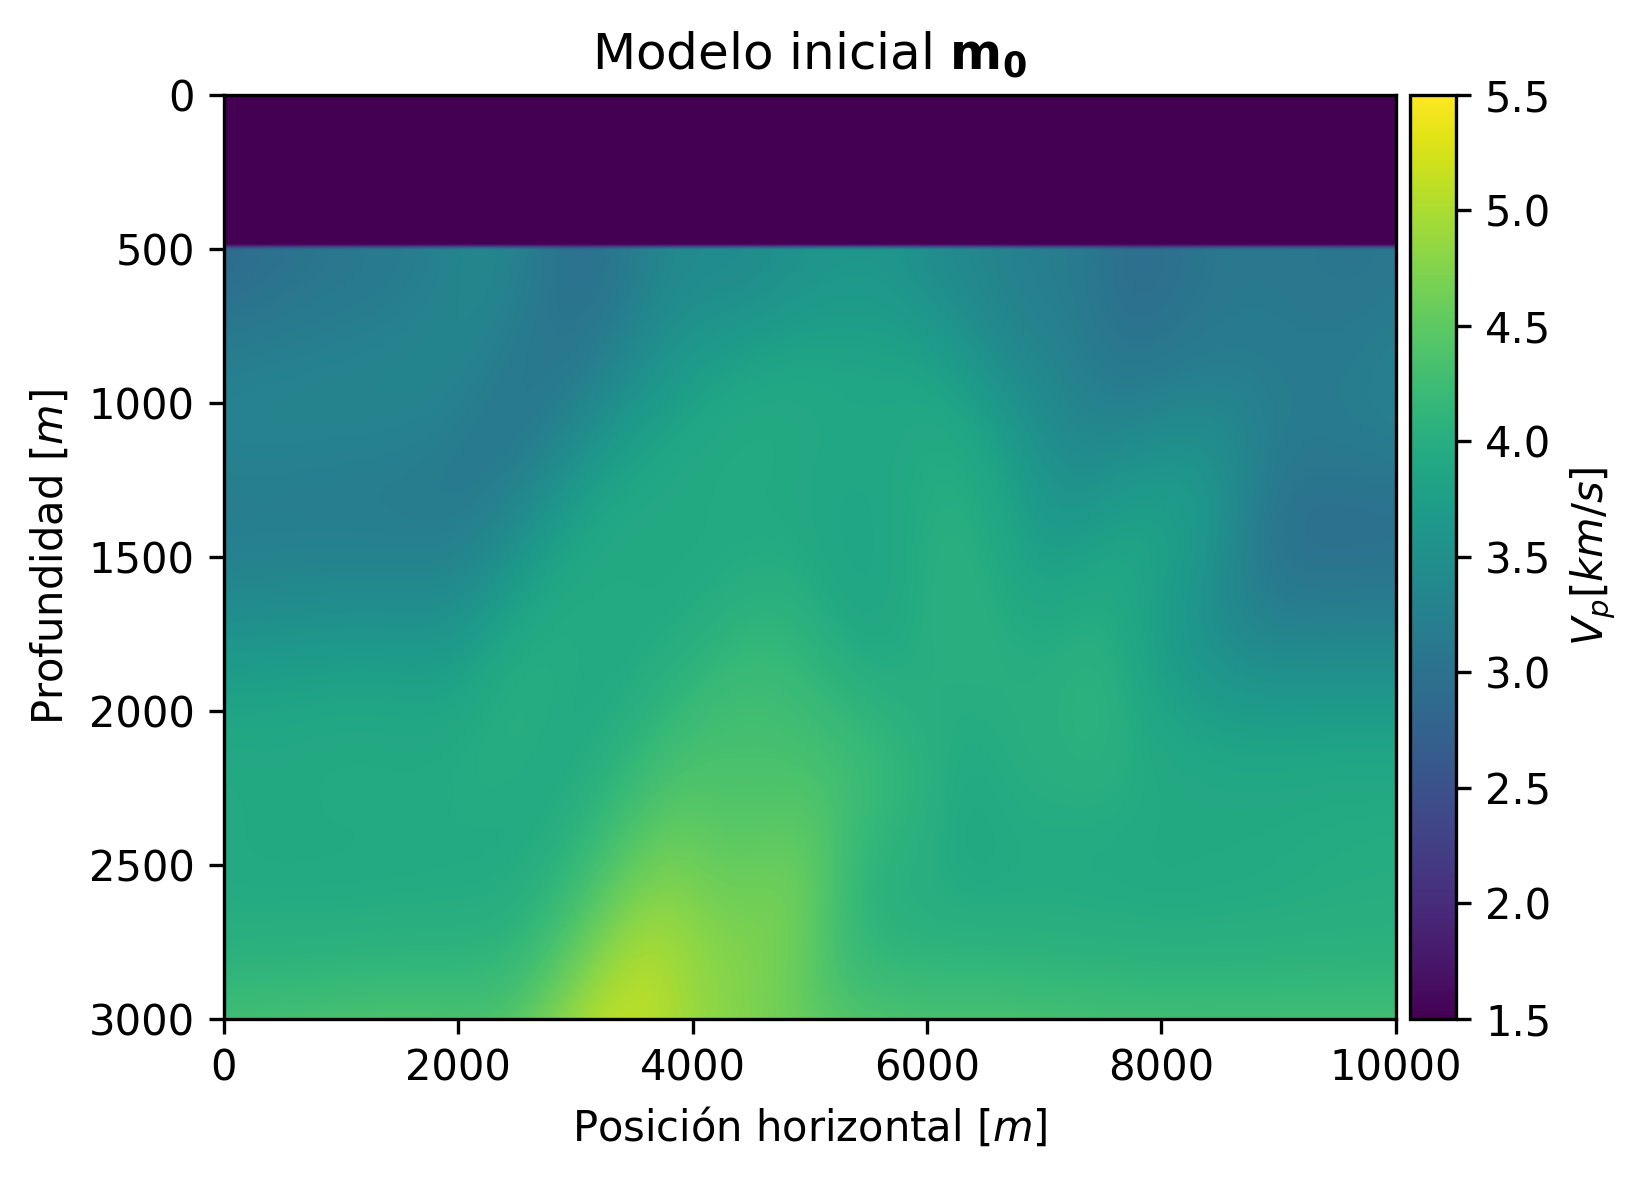

In [25]:
fig=figure(figsize=(6,4), dpi=300);
im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
display(fig)
savefig("fwi1.jpeg",format="jpeg");

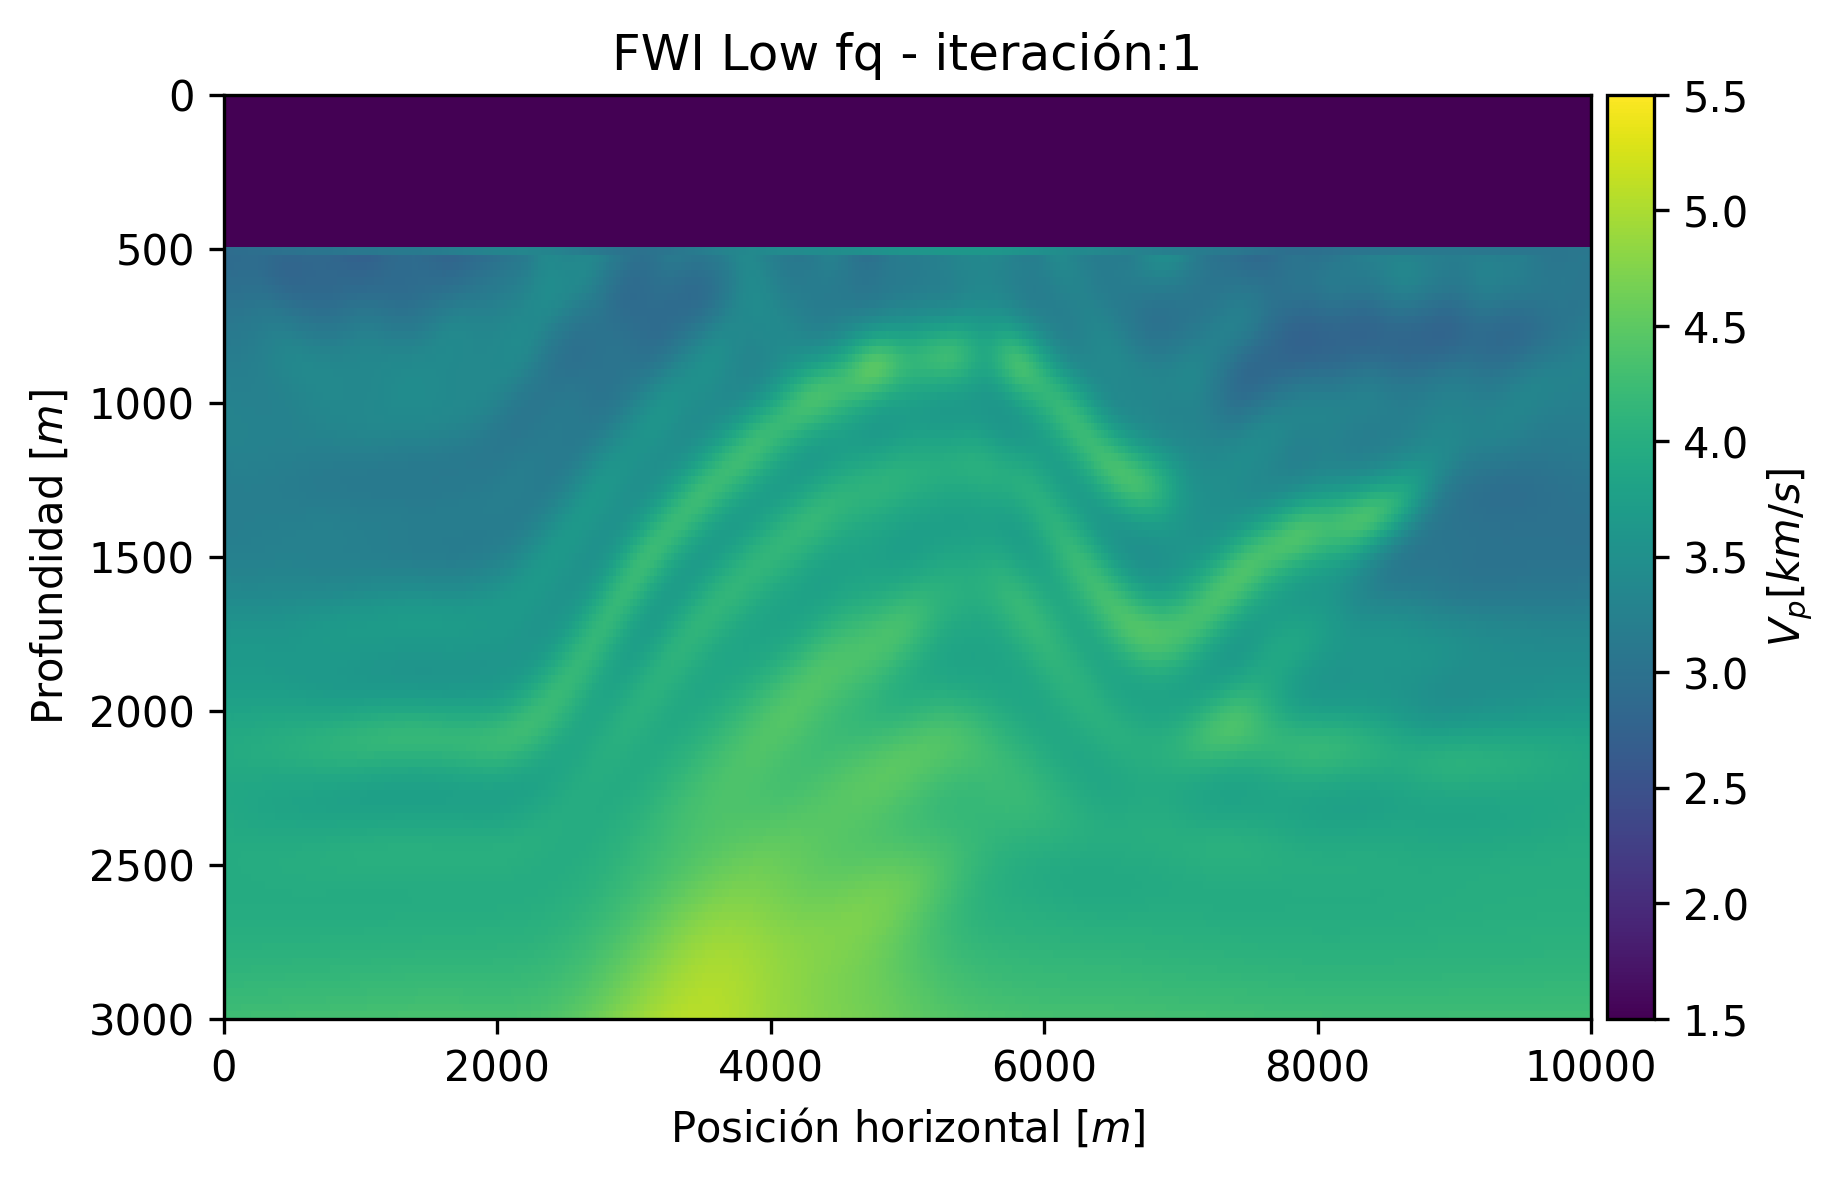

/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [11]:
nt = 1
fwi_ = sqrt.(1f0./adjoint(reshape(m0_values[:, nt], (401,121))));
fig=figure(figsize=(7,4), dpi=300);
im = imshow(fwi_, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI Low fq - iteración:"*string(nt))
display(fig)

In [25]:
fwi = sqrt.(1f0./adjoint(reshape(m0_values[:, 30], (401,121))));

In [35]:
writedlm("fwi_l_results/fwi.txt", m0_values)

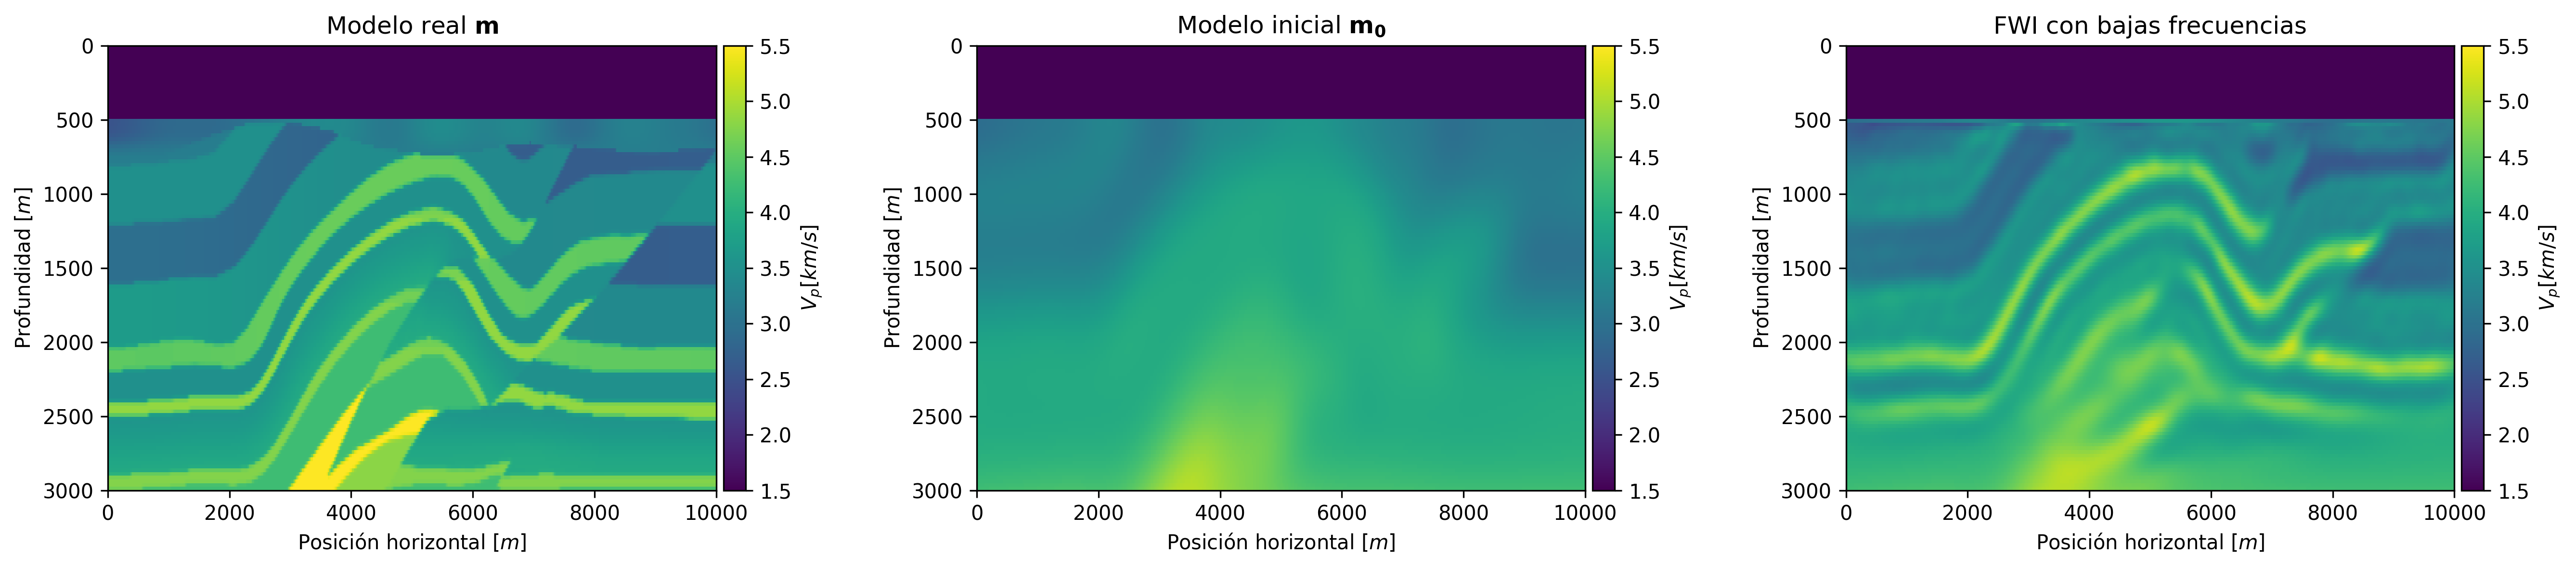

/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geopc3/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [13]:
fig=figure(figsize=(22,4), dpi=300);
subplot(131)
im = imshow(v', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI con bajas frecuencias")
display(fig)

In [14]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi').^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.1265017
El error cuadrático medio de FWI es: 

0.05322102524116629


In [15]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi')) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 7.9860744
Porcentaje de error (FWI): 4.489323677818051


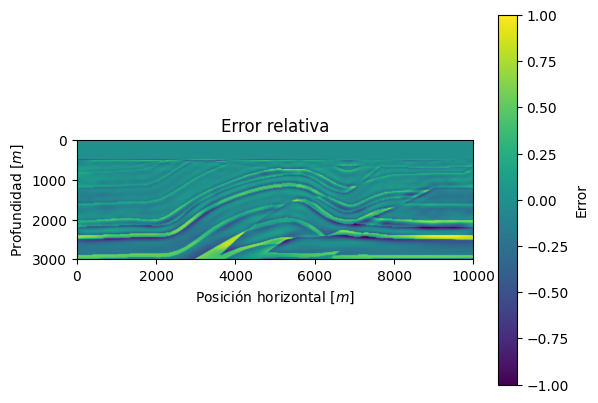

In [16]:
difs = v'-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-1, vmax=1)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

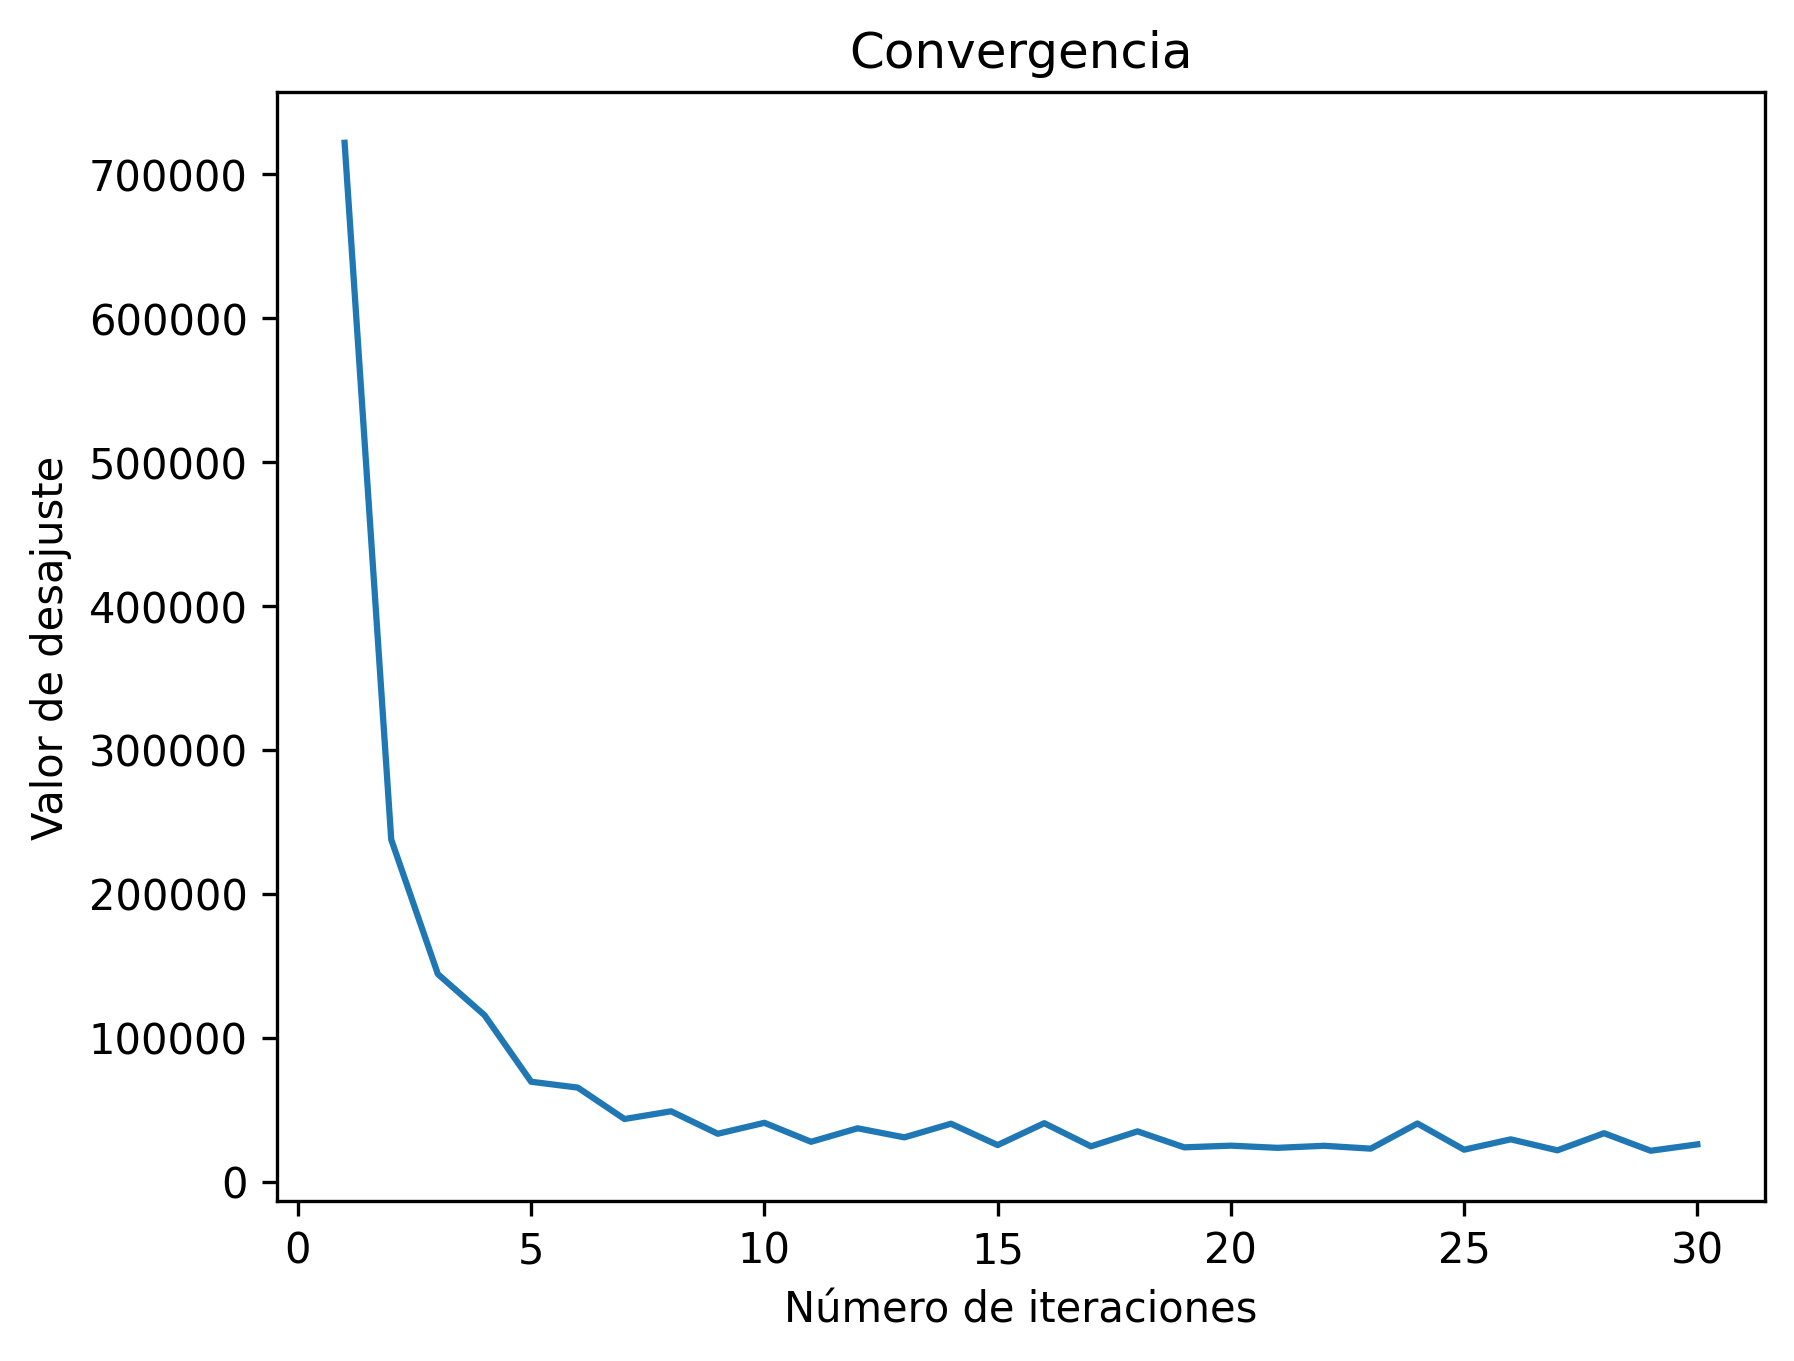

In [17]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [18]:
dm = mm - m0;

In [19]:
save("model_overthrust_fwi_result_low_f.jld", "n", n, "d", d, "o", o, "m", mm, "m0", model0.m.data, "dm", dm, "fwi", fwi')

In [20]:
writedlm("fwi_l_results/m0.txt", v0)
writedlm("fwi_l_results/fwi.txt", m0_values)
writedlm("fwi_l_results/mtrue.txt", v)
writedlm("fwi_l_results/fval.txt", fhistory_SGD)

In [21]:
canonicalize(t2 - t1)

3 minutes, 18 seconds, 586 milliseconds

In [22]:
t2 - t1

198586 milliseconds